In [45]:
# Импорт всех библиотек, модулей и методов
%load_ext autoreload
%autoreload 2

import pandas as pd  # Импортируем библиотеку pandas
import matplotlib.pyplot as plt  # Импортируем библиотеку matplotlib.pyplot
import warnings

from statsmodels.tsa.stattools import adfuller  # Импортируем функцию adfuller из statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Импортируем функции для визуализации автокорреляции и частичной автокорреляции
from statsmodels.tsa.arima.model import ARIMA  # Импортируем модель ARIMA
from sklearn.metrics import mean_squared_error  # Импортируем метрику mean_squared_error

from Modules.data_loader import data_load  # Импортируем функцию для загрузки данных
from Modules.eda import perform_eda, analyze_missing_values, analyze_returns, print_comparison_results  # Импортируем функции для выполнения EDA
from Modules.preprocessing import preprocess_data, clean_data, fill_missing_sales  # Импортируем функции для предварительной обработки данных
from Modules.feature_engineering import create_invoice_features, create_customer_features, create_date_features  # Импортируем функции для создания фичей
from Modules.visualization import plot_line_chart, visualize_missing_data, plot_heatmap, correlation_matrix, visualize_time_series, visualize_predictions  # Импортируем функции для визуализации данных
from Modules.modeling import arima_model, auto_arima_model, sarima_model, lstm_model  # Импортируем модели

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

from Modules.data_loader import data_load  # Импортируем функцию для загрузки данных
from Modules.eda import perform_eda, analyze_missing_values, analyze_returns, print_comparison_results  # Импортируем функции для выполнения EDA
from Modules.preprocessing import preprocess_data, clean_data, fill_missing_sales  # Импортируем функции для предварительной обработки данных
from Modules.feature_engineering import create_invoice_features, create_customer_features, create_date_features  # Импортируем функции для создания фичей
from Modules.visualization import plot_line_chart, visualize_missing_data, plot_heatmap, correlation_matrix, visualize_time_series, visualize_predictions  # Импортируем функции для визуализации данных# 1. Загрузка данных

In [3]:
# Модификации датасета:
# df_entire - датасет целиком AS IS на сейте
# df_encoded - датасет после применения LabelEncoder и преобразования InvoiceDate из типа 'object' в 'datetime64'
# df_no_missing - датасет с офильтрованныи пропусками в поле CustomerID - их не логично заполнять средним или мединным значением,
#                но можно не убирать при агрегированном среднесуточном анализе без разбивки по клиентам.
# df_next - датасет после выбора пользователем, сохранить или оставить покупателей без CustomerID
# df_sales - датасет только по продажам (без возвратов)
# df_sales_clean - датасет после очистки ошибок данных
# df_invoice_features - датасет дополнен фичами для каждого чека на основе группировки по InvoiceNo
# df_customer_features - датасет дополнен фичами для каждого покупателя на основе группировки по CustomerID
# df_date_features - датасет дополнен фичами для каждого дня на основе группировки по Date
# df_filled - датасет с заполненными днями-пропусками на среднеарифметическое за текущую неделю

In [4]:
# Загрузка данных
df_entire = data_load()

if df_entire is None:
    print("\nОшибка: данные не загружены.")


Откуда вы хотите загрузить данные?
    Предпочтительнее загрузка данных из архива, т.к. на сайте отсутствуют поля ['InvoiceNo', 'StockCode'].
    Введите 'site' для загрузки с сайта или 'zip' для загрузки из архива: zip


Данные загружены из файла: C:\Users\user\Documents\Belhard - Data Science\Practical tasks\HW_5\Modules\..\Data\online_retail_csv.csv


In [5]:
# 2. EDA анализ

In [6]:
# 2.1 Первичный просмотр датасета: поля, типы данных, статисический срез

perform_eda(df_entire)


**Поля и типы данных:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

**Первые строки данных:**

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATE

In [7]:
# 2.2 Энкодирование категориальных переменных

# Метод так же создает индекс CustomerID_missing, помечающий пропуски в CustomerID
df_encoded, label_encoders = preprocess_data(df_entire)


Трансформация данных и энкодирование категориальных переменных завершены. Файл сохранен в C:\Users\user\Documents\Belhard - Data Science\Practical tasks\HW_5\Data\label_encodings.txt.


In [8]:
# 2.3 Анализ пропущенных значений в CustomerID
analyze_missing_values(df_encoded)  # Явно передаем df_encoded и df_no_missing

print(f"""
Пропуски в поле CustomerID не логично заполнять средним или медианным значением - это может создать покупателя с аномальным поведением.
Для дальнейшей работы с агрегированными данными (прогноз всех покупок на дату) пропуски можно не убирать и отправлять в методы датасет df_entire.
Для прогноза по покупателям в анализ следует отправлять очищенный от пропусков датасет df_no_missing.""")

# Создание df_no_missing - датасета с отфильтрованными пропусками в поле CustomerID
df_no_missing = df_encoded[df_encoded['CustomerID_missing'] == 0]


Анализ данных без пропусков в CustomerID:
Количество строк в df_no_missing: 406829

**Поля и типы данных:**

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           406829 non-null  object        
 1   StockCode           406829 non-null  object        
 2   Description         406829 non-null  int32         
 3   Quantity            406829 non-null  int64         
 4   InvoiceDate         406829 non-null  datetime64[ns]
 5   UnitPrice           406829 non-null  float64       
 6   CustomerID          406829 non-null  int32         
 7   Country             406829 non-null  int32         
 8   CustomerID_missing  406829 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1), object(2)
memory usage: 24.8+ MB
None

**Первые строки данных:**

  InvoiceNo StockCode  Descriptio

In [9]:
# Запрос у пользователя, стоит ли сохранять пропущенные CustomerID

missing_customer = input(f"""
Хотите сохранить клиентов без указанного CustomerID для дальнейшей обработки?
Введите 'y' для сохранения их в обработке или 'n' для исключения:
""")

if missing_customer.lower() == 'n':
    df_next = df_no_missing
    print("Покупатели без CustomerID исключены из дальнейшей обработки.")
elif missing_customer.lower() == 'y':
    df_next = df_encoded
    print("Покупатели без CustomerID сохранены в дальнейшей обработки.")
else:
    print("Ошибка: некорректный выбор. По умолчанию клиенты без указанного CustomerID исключены из дальнейшей обработки.")
    df_next = df_no_missing


Хотите сохранить клиентов без указанного CustomerID для дальнейшей обработки?
Введите 'y' для сохранения их в обработке или 'n' для исключения:
 y


Покупатели без CustomerID сохранены в дальнейшей обработки.


In [10]:
# 2.4 Анализ доли возвратов в датасете

print("Анализ доли возвратов:\n")
df_sales = analyze_returns(df_next)

print("\nПродолжаем работу с данными продаж (без возвратов)")

Анализ доли возвратов:

Столбец IsReturn добавлен:
  InvoiceNo StockCode  Description  Quantity         InvoiceDate  UnitPrice  \
0    536365    85123A         3918         6 2010-12-01 08:26:00       2.55   
1    536365     71053         3926         6 2010-12-01 08:26:00       3.39   
2    536365    84406B          913         8 2010-12-01 08:26:00       2.75   
3    536365    84029G         1910         6 2010-12-01 08:26:00       3.39   
4    536365    84029E         2911         6 2010-12-01 08:26:00       3.39   

   CustomerID  Country  CustomerID_missing  IsReturn  
0        4049       36                   0     False  
1        4049       36                   0     False  
2        4049       36                   0     False  
3        4049       36                   0     False  
4        4049       36                   0     False  
Количество возвратов: 9288
Сумма возвратов: -896812.49
Количество продаж: 532621
Сумма продаж: 10644560.42
Процент возвратов по количеству: 1.71

In [11]:
# 3. Очистка данных

In [12]:
# Очистка данных
df_sales_clean = clean_data(df_sales)


Общее количество товаров до очистки: 5454024
Общая сумма продаж до очистки: 10644560.42

Инвойсы с отрицательными значениями Quantity:
['536589' '536764' '536996' ... '581213' '581226' '581422']
Количество удаленных инвойсов: 1336
Количество удаленых товаров: 206957
Доля от общего количества товаров: 3.79%
Сумма удаленых продаж: 0.00
Доля от общей суммы продаж: 0.00%

Инвойсы с отрицательными значениями UnitPrice:
['A563186' 'A563187']
Количество удаленных инвойсов: 2
Количество удаленых товаров: 2
Доля от общего количества товаров: 0.00%
Сумма удаленых продаж: 22124.12
Доля от общей суммы продаж: 0.21%

Инвойсы, не соответствующие условию 'a 6-digit integral number':
['A563185']
Количество удаленных инвойсов: 1
Количество удаленых товаров: 1
Доля от общего количества товаров: 0.00%
Сумма удаленых продаж: 11062.06
Доля от общей суммы продаж: 0.10%

Инвойсы с разными InvoiceDate или CustomerID для одного InvoiceNo:
['536591' '540185' '541596' '541631' '541809' '541816' '541849' '542217

In [13]:
# 4. Создание фичей

In [14]:
# Создание фичей для каждого чека
df_invoice_features = create_invoice_features(df_sales_clean)

print("Фичи для каждого чека:\n", df_invoice_features.head())

print("Статистика:\n", df_invoice_features.describe())

Фичи для каждого чека:
   InvoiceNo  TotalAmount  MinUnitPrice  MaxUnitPrice  MedianUnitPrice  \
0    536365       139.12          2.55          7.65             3.39   
1    536366        22.20          1.85          1.85             1.85   
2    536367       278.73          1.65          9.95             4.60   
3    536368        70.05          4.25          4.95             4.95   
4    536369        17.85          5.95          5.95             5.95   

   MinQuantity  MaxQuantity  TotalQuantity         InvoiceDate  CustomerID  
0            2            8             40 2010-12-01 08:26:00        4049  
1            6            6             12 2010-12-01 08:28:00        4049  
2            2           32             83 2010-12-01 08:34:00         541  
3            3            6             15 2010-12-01 08:34:00         541  
4            3            3              3 2010-12-01 08:35:00         541  
Статистика:
          TotalAmount  MinUnitPrice  MaxUnitPrice  MedianUnitPr

In [15]:
# Создание фичей для каждого абонента
df_customer_features = create_customer_features(df_invoice_features)

print("Фичи для каждого абонента:\n", df_customer_features.head())

print("Статистика:\n", df_customer_features.describe())

Фичи для каждого абонента:
    CustomerID   FirstPurchaseDate    LastPurchaseDate  TotalPurchaseCount  \
0           0 2010-12-01 11:52:00 2011-12-09 10:26:00                2177   
1           1 2011-01-18 10:01:00 2011-01-18 10:01:00                   1   
2           2 2010-12-07 14:57:00 2011-12-07 15:52:00                   7   
3           3 2010-12-16 19:09:00 2011-09-25 13:13:00                   4   
4           4 2011-11-21 09:51:00 2011-11-21 09:51:00                   1   

   TotalPurchaseAmount  AveragePurchaseAmount  TotalQuantity  \
0           1700784.30             781.251401         467707   
1             77183.60           77183.600000          74215   
2              4310.00             615.714286           2458   
3              1797.24             449.310000           2341   
4              1757.55            1757.550000            631   

   DaysSinceFirstPurchase  LastMonthPurchaseAmount  
0                     373                374822.67  
1                 

In [16]:
# Создание фичей на основе группировки по дате
df_date_features = create_date_features(df_sales_clean)

print("Фичи на основе группировки по дате:\n", df_date_features.head())

print("Статистика:\n", df_date_features.describe())

Фичи, созданные на основе группировки по дате:
1. 'Date': Дата (без времени).
2. 'TotalSalesAmount': Общая сумма продаж за день.
3. 'TotalSalesQuantity': Общее количество товаров, проданных за день.
4. 'AverageSalesAmount': Средняя сумма продаж за день.
5. 'AverageSalesQuantity': Среднее количество товаров, проданных за день.
6. 'NumberOfTransactions': Количество транзакций за день.
7. 'DayOfWeek': День недели (0 = понедельник, 1 = вторник и т.д.).
8. 'WeekOfYear': Номер недели в году.
9. 'MonthOfYear': Месяц года.
Фичи на основе группировки по дате:
          Date  TotalSalesAmount  TotalSalesQuantity  AverageSalesAmount  \
0  2010-12-01          58762.47               26914           19.323403   
1  2010-12-02          47748.38               31348           23.133905   
2  2010-12-03          46943.71               16471           21.733199   
3  2010-12-05          31774.95               16451           11.729402   
4  2010-12-06          54830.46               21951           14.34

In [17]:
# 5. Визуализация данных

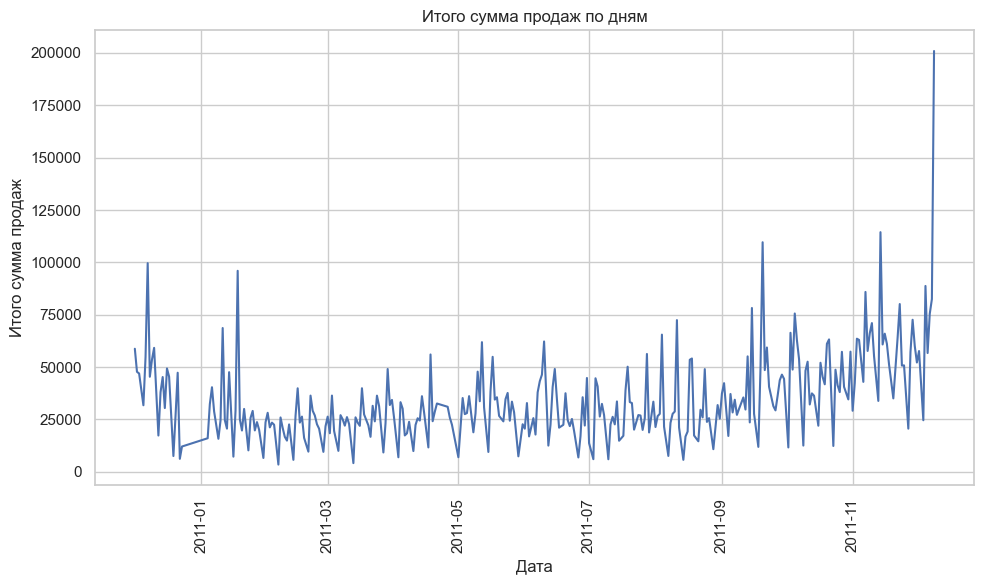

Сумма продаж имеет тренд на увеличение к концу 2011г.
Скорее всего в конце декабря 2010 начале января 2011 пропущено несколько дней


In [18]:
# 5.1 Визуализация: Линейный график для Total Sales Amount по дням
plot_line_chart(df_date_features, 'Date', 'TotalSalesAmount', 'Итого сумма продаж по дням', 'Дата', 'Итого сумма продаж')

print("""Сумма продаж имеет тренд на увеличение к концу 2011г.
Скорее всего в конце декабря 2010 начале января 2011 пропущено несколько дней""")

Пропущенные даты на 51-52 неделях 2010г и 16-17 неделях 2011г:
         Date  Year  Week  DayOfWeek
3  2010-12-24  2010    51     Friday
4  2010-12-25  2010    51   Saturday
5  2010-12-26  2010    51     Sunday
6  2010-12-27  2010    52     Monday
7  2010-12-28  2010    52    Tuesday
8  2010-12-29  2010    52  Wednesday
9  2010-12-30  2010    52   Thursday
10 2010-12-31  2010    52     Friday
11 2011-01-01  2011    52   Saturday
12 2011-01-02  2011    52     Sunday
13 2011-01-03  2011     1     Monday
14 2011-01-08  2011     1   Saturday
29 2011-04-22  2011    16     Friday
30 2011-04-23  2011    16   Saturday
31 2011-04-24  2011    16     Sunday
32 2011-04-25  2011    17     Monday
33 2011-04-29  2011    17     Friday
34 2011-04-30  2011    17   Saturday
35 2011-05-02  2011    18     Monday
36 2011-05-07  2011    18   Saturday
40 2011-05-30  2011    22     Monday
41 2011-06-04  2011    22   Saturday
54 2011-08-29  2011    35     Monday
55 2011-09-03  2011    35   Saturday


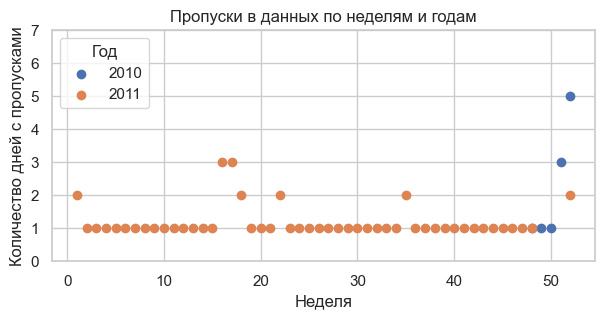

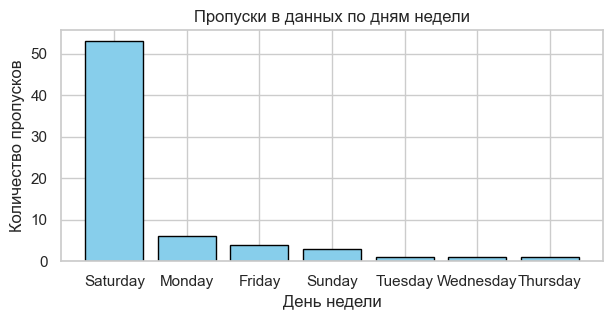

Подтвердилась гипотеза о пропусках на 51-52 неделях 2010г, а так же обнаружены частичные пропуски на 16-17 неделях 2011г.


In [19]:
# 5.2 Визуализация пропусков дней в данных
visualize_missing_data(df_date_features)

print("Подтвердилась гипотеза о пропусках на 51-52 неделях 2010г, а так же обнаружены частичные пропуски на 16-17 неделях 2011г.")


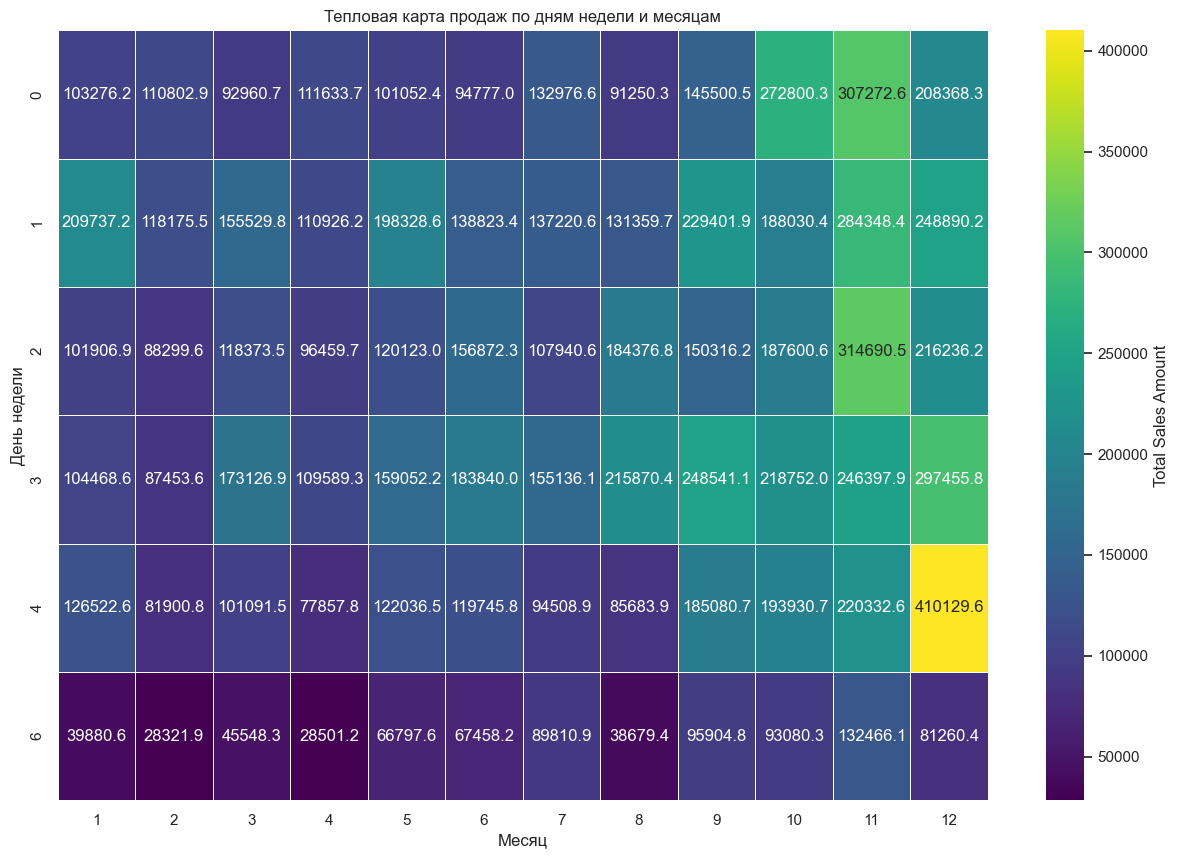

Самые 'тёплые' месяцы года - ноябрь и декабрь;
самый 'холодный' день недели - воскресенье.


In [20]:
# 5.3 Визуализация: Тепловая карта продаж по дням недели и месяцам
plot_heatmap(df_date_features, 'Тепловая карта продаж по дням недели и месяцам', 'Месяц', 'День недели')

print("""Самые 'тёплые' месяцы года - ноябрь и декабрь;
самый 'холодный' день недели - воскресенье.""")

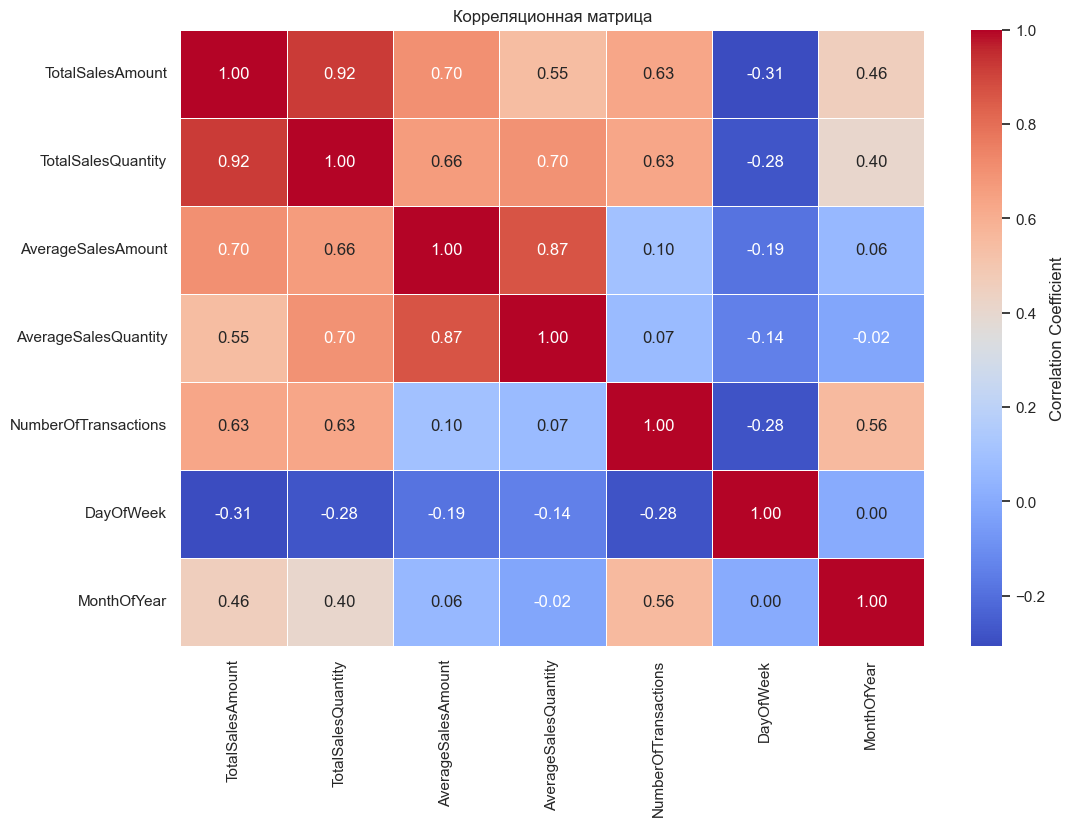

In [21]:
# 5.4 Визуализация: Матрица корреляций
correlation_matrix(df_date_features)

In [22]:
# 6. Заполнение пустых дней

In [23]:
# Заполнение пропущенного дня в датасете средним арифметическим за неделю
df_filled = fill_missing_sales(df_date_features)

print("""\nТаня, если в выборке совсем был пропущен день (чаще всего суббота = выходной), я заменила его среднедневным значением за неделю.
Мне показалось, что это максимально сохранит адекватность тренда на увеличение продаж в декабре.
Но что делать с обработкой таких дней, как 2010-12-27, когда запись в датасете есть со значением NaN?
Я это понимаю, как "Магазин работал, но продаж не было. Так тоже бывает. Как своеобразный выброс."
Возможно, адекватнее его заменять не среднедневным значением, а 0? Но не сойдут ли от этого с ума модели?""")

Пропущенные значения (по дням):
           Date  TotalSalesAmount  TotalSalesAmount_new
3   2010-12-04               NaN          50960.034000
10  2010-12-11               NaN          75840.612727
17  2010-12-18               NaN          36002.033333
23  2010-12-24               NaN          23092.325000
24  2010-12-25               NaN          23092.325000
..         ...               ...                   ...
339 2011-11-05               NaN          49730.515000
346 2011-11-12               NaN          61637.530000
353 2011-11-19               NaN          64770.406667
360 2011-11-26               NaN          52693.091667
367 2011-12-03               NaN          50960.034000

[69 rows x 3 columns]
Значения, замененные по причине NaN:
          Date  TotalSalesAmount  TotalSalesAmount_new
26 2010-12-27               NaN             23092.325
27 2010-12-28               NaN             23092.325
28 2010-12-29               NaN             23092.325
29 2010-12-30               Na

In [24]:
# 7. Построение моделей

In [25]:
# 7.1 Выбор временного ряда для моделирования

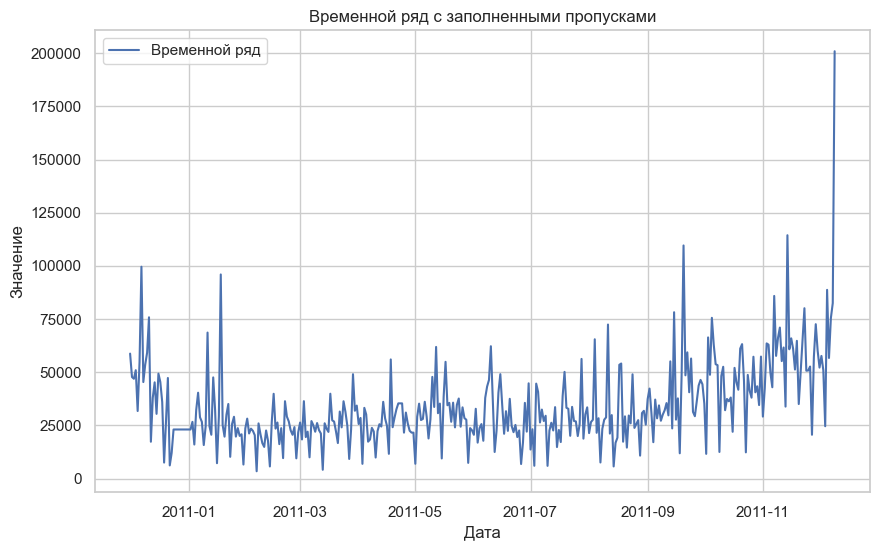

In [26]:
# Использование существующего датасета df_date_features
ts = df_filled[['Date', 'TotalSalesAmount']]
ts.set_index('Date', inplace=True)

# Задание частоты временного ряда
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')  # Частоту = день


# Визуализация исходного временного ряда
visualize_time_series(ts, title='Временной ряд с заполненными пропусками')


ADF Statistic: -0.09410568119714674
p-value: 0.9500224748811911

Временной ряд не является стационарным. Применим дифференцирование
ADF Statistic (после дифференцирования): -6.062391116748094
p-value (после дифференцирования): 1.203909541317846e-07

Результат ADF теста показывает, что после дифференцирования временной ряд стал стационарным


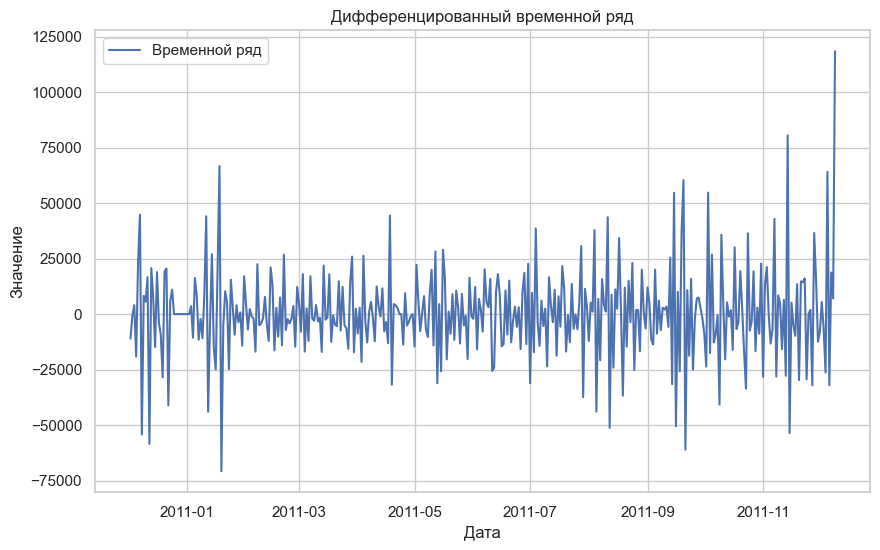

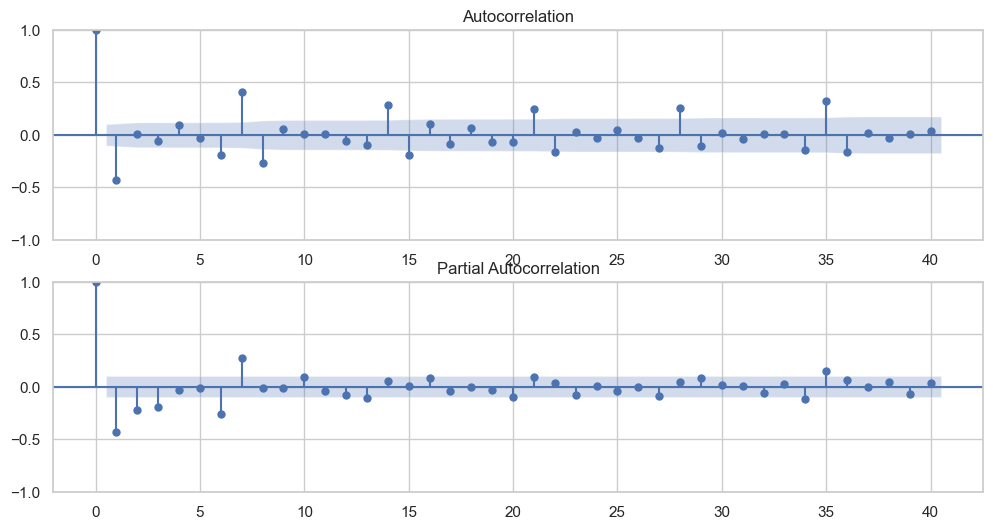

In [27]:
# Проверка на стационарность с помощью ADF теста
result = adfuller(ts['TotalSalesAmount'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

print('\nВременной ряд не является стационарным. Применим дифференцирование')

# Если p-value > 0.05, временной ряд нестационарный
# Дифференцирование данных для достижения стационарности
ts_diff = ts.diff().dropna()

# Повторный тест ADF
result_diff = adfuller(ts_diff['TotalSalesAmount'])
print('ADF Statistic (после дифференцирования):', result_diff[0])
print('p-value (после дифференцирования):', result_diff[1])

print('\nРезультат ADF теста показывает, что после дифференцирования временной ряд стал стационарным')

# Визуализация дифференцированного временного ряда
visualize_time_series(ts_diff, title='Дифференцированный временной ряд')

# Визуализация автокорреляции и частичной автокорреляции
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(ts_diff['TotalSalesAmount'], ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(ts_diff['TotalSalesAmount'], ax=plt.gca(), lags=40)
plt.show()

# Находим минимальное значение даты
start_date = ts.index.min()

# Создаем индексы для дифференцированного временного ряда
ts_diff.index = pd.date_range(start=start_date, periods=len(ts_diff), freq='D')


# Разделение данных на обучающую и тестовую выборки с учетом индексов
train_size = int(len(ts_diff) * 0.8)
train_data, test_data = ts_diff[:train_size], ts_diff[train_size:]


In [28]:
# 7.2 ARIMA без подбора параметров

                               SARIMAX Results                                
Dep. Variable:       TotalSalesAmount   No. Observations:                  298
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3306.189
Date:                Wed, 26 Feb 2025   AIC                           6618.379
Time:                        23:44:18   BIC                           6629.460
Sample:                    12-01-2010   HQIC                          6622.815
                         - 09-24-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4532      0.037    -12.316      0.000      -0.525      -0.381
ma.L1         -1.0000      0.052    -19.070      0.000      -1.103      -0.897
sigma2      2.683e+08   1.95e-10   1.37e+18      0.0

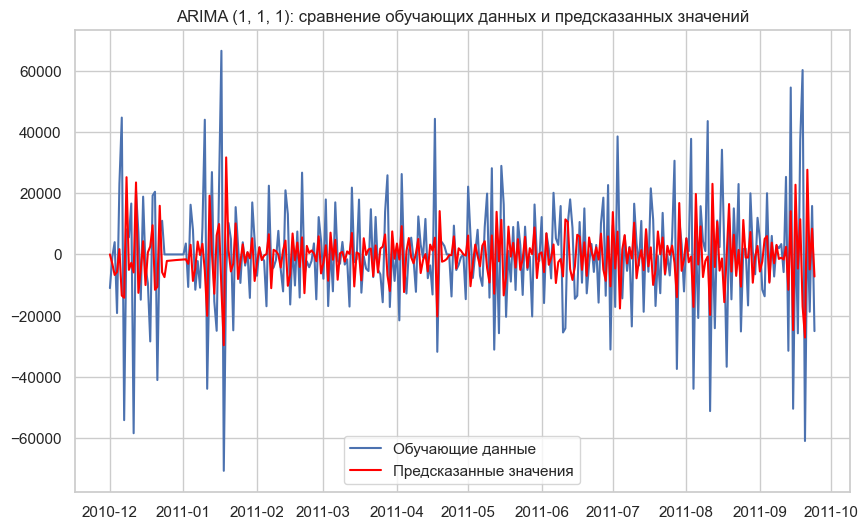

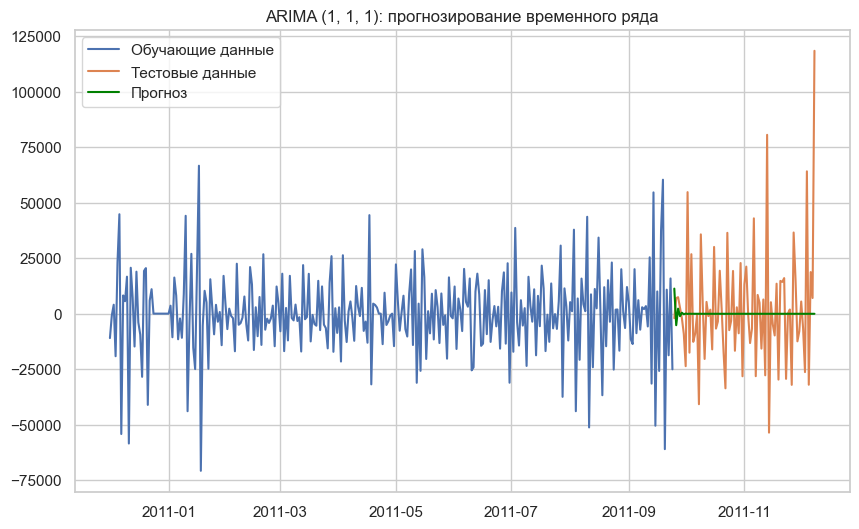

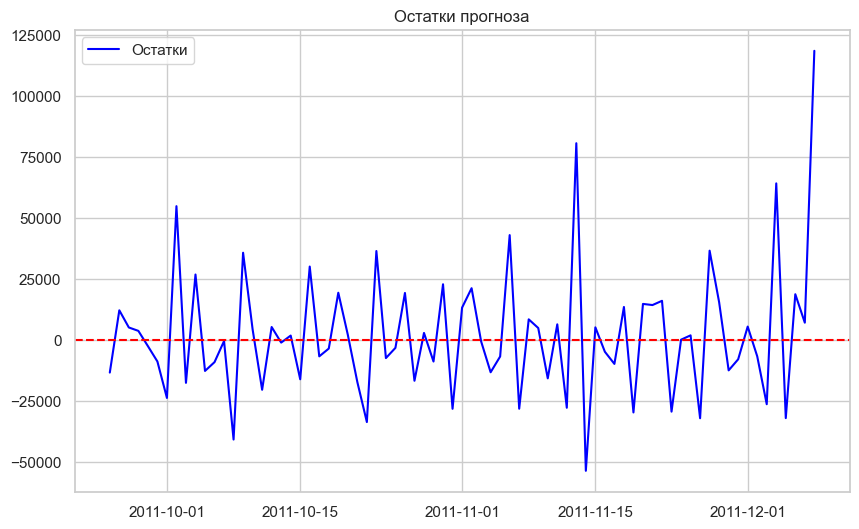

Mean Absolute Error (MAE): 18948.202
Mean Squared Error (MSE): 734720356.616
Root Mean Squared Error (RMSE): 27105.726
Mean Absolute Percentage Error (MAPE): nan%

На обучающей выборке предсказанные значения модели ARIMA(1, 1, 1) в целом следуют за трендом обучающих данных,
с некоторыми отклонениями на экстремальных значениях-выбросах. Модель адекватно улавливает основные тенденции временного ряда.


На тестовой выборке визуализация прогноза, низкие метрики качества говорят о том, что модель скорее не адекватна
и требуется дополнительная настройка параметров.

MAE (Mean Absolute Error): ARIMA = 18948.202.
MSE (Mean Squared Error): ARIMA = 734720356.616.
RMSE (Root Mean Squared Error): ARIMA = 27105.726).


In [42]:
# Обучение модели ARIMA и получение прогноза
order = (1, 1, 1)
ARIMA_model_fit, ARIMA_forecast, ARIMA_fitted_values, ARIMA_mae, ARIMA_mse, ARIMA_rmse, ARIMA_mape = arima_model(train_data, test_data, order)

print(f"""
На обучающей выборке предсказанные значения модели ARIMA(1, 1, 1) в целом следуют за трендом обучающих данных,
с некоторыми отклонениями на экстремальных значениях-выбросах. Модель адекватно улавливает основные тенденции временного ряда.
""")

print("""
На тестовой выборке визуализация прогноза, низкие метрики качества говорят о том, что модель скорее не адекватна
и требуется дополнительная настройка параметров.
""")

print(f"""MAE (Mean Absolute Error): ARIMA = {ARIMA_mae:.3f}.
MSE (Mean Squared Error): ARIMA = {ARIMA_mse:.3f}.
RMSE (Root Mean Squared Error): ARIMA = {ARIMA_rmse:.3f}.""")


In [33]:
# 7.3 ARIMA с автоподбором параметров

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6548.783, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6698.833, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6632.513, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6541.799, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6543.362, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6541.234, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6543.589, Time=0.39 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=6543.280, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6543.864, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6544.599, Time=0.11 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 1.528 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observati

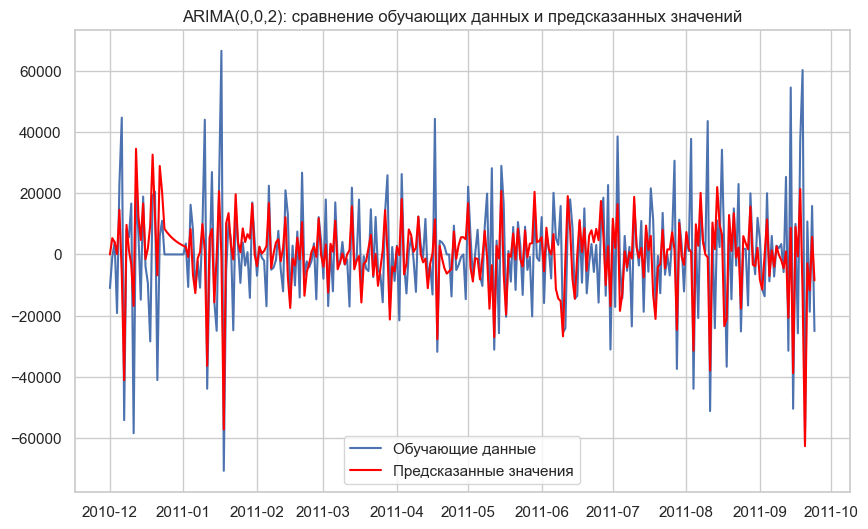

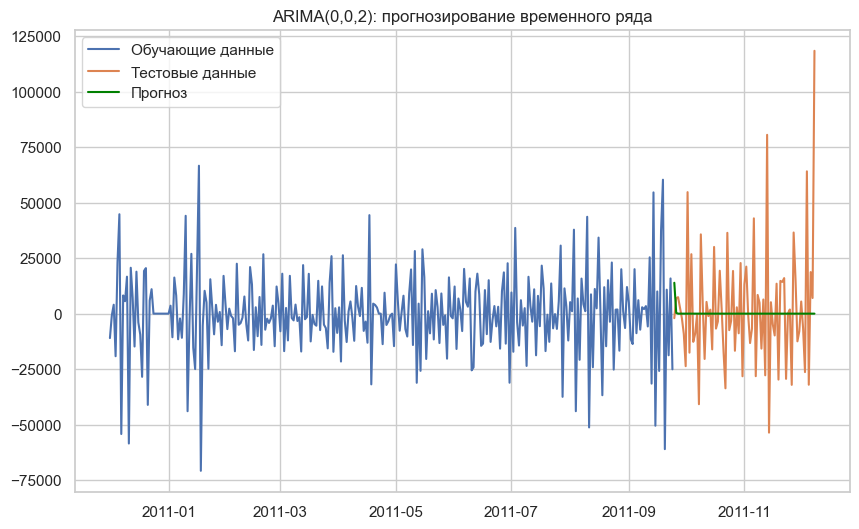

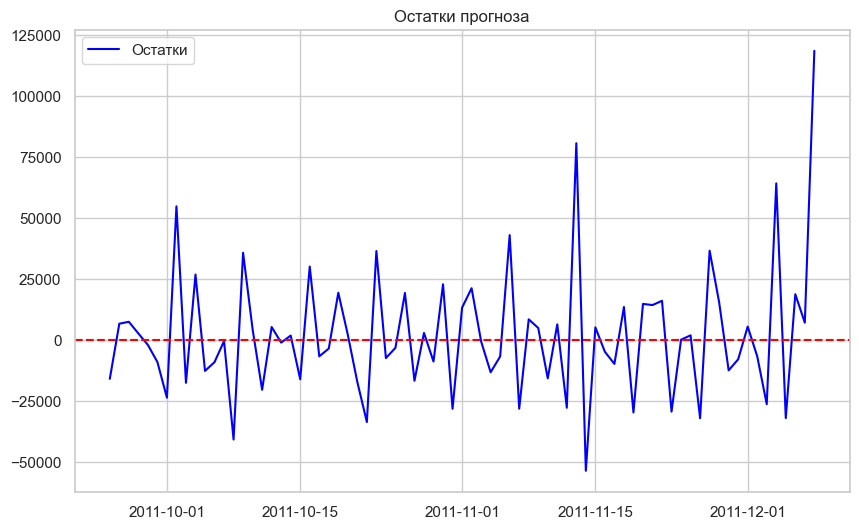

Mean Absolute Error (MAE): 18921.477
Mean Squared Error (MSE): 734245326.329
Root Mean Squared Error (RMSE): 27096.962
Mean Absolute Percentage Error (MAPE): nan%

На обучающей выборке предсказанные значения в целом следуют за трендом обучающих данных, с некоторыми отклонениями на экстремальных выбросах.
Это указывает на то, что модель в адекватно улавливает основные тенденции временного ряда.
Лучшая модель: ARIMA(0,0,2)


Моделирование на тестовой выборке, низкие метрики качества, график остатков, не являющийся белым шумом,
показывают, что лучшая модель ARIMA(0,0,2) не способна адекватно предсказывать резкие колебания во временном ряде,
что приводит к значительным отклонениям от реальных значений.

MAE (Mean Absolute Error): auto_ARIMA = 18921.477.
MSE (Mean Squared Error): auto_ARIMA = 734245326.329.
RMSE (Root Mean Squared Error): auto_ARIMA = 27096.962.


In [43]:
%load_ext autoreload
%autoreload 2
from Modules.modeling import auto_arima_model

# Обучение модели ARIMA с автоподбором параметров и получение прогноза
ARIMA_auto_model, ARIMA_best_model, ARIMA_auto_forecast, ARIMA_auto_fitted_values, ARIMA_auto_mae, ARIMA_auto_mse, ARIMA_auto_rmse, ARIMA_auto_mape = auto_arima_model(train_data, test_data)

print(f"""
На обучающей выборке предсказанные значения в целом следуют за трендом обучающих данных, с некоторыми отклонениями на экстремальных выбросах.
Это указывает на то, что модель в адекватно улавливает основные тенденции временного ряда.
Лучшая модель: ARIMA({ARIMA_best_model.order[0]},{ARIMA_best_model.order[1]},{ARIMA_best_model.order[2]})
""")

print(f"""
Моделирование на тестовой выборке, низкие метрики качества, график остатков, не являющийся белым шумом,
показывают, что лучшая модель ARIMA({ARIMA_best_model.order[0]},{ARIMA_best_model.order[1]},{ARIMA_best_model.order[2]}) не способна адекватно предсказывать резкие колебания во временном ряде,
что приводит к значительным отклонениям от реальных значений.
""")

print(f"""MAE (Mean Absolute Error): auto_ARIMA = {ARIMA_auto_mae:.3f}.
MSE (Mean Squared Error): auto_ARIMA = {ARIMA_auto_mse:.3f}.
RMSE (Root Mean Squared Error): auto_ARIMA = {ARIMA_auto_rmse:.3f}.""")


In [55]:
# Сравнение метрик ARIMA и auto_ARIMA
print(f"""Сравнение метрик auto_ARIMA({ARIMA_best_model.order[0]},{ARIMA_best_model.order[1]},{ARIMA_best_model.order[2]}) и ARIMA(1,1,1)

MAE (Mean Absolute Error): auto_ARIMA = {ARIMA_auto_mae:.3f} < ARIMA = {ARIMA_mae:.3f}.
MSE (Mean Squared Error): auto_ARIMA = {ARIMA_auto_mse:.3f} < ARIMA = {ARIMA_mse:.3f}.
RMSE (Root Mean Squared Error): auto_ARIMA = {ARIMA_auto_rmse:.3f} < ARIMA = {ARIMA_rmse:.3f}).

Модель auto_ARIMA({ARIMA_best_model.order[0]},{ARIMA_best_model.order[1]},{ARIMA_best_model.order[2]}) точнее, хоть и не значительно.""")


Сравнение метрик auto_ARIMA(0,0,2) и ARIMA(1,1,1)

MAE (Mean Absolute Error): auto_ARIMA = 18921.477 < ARIMA = 18948.202.
MSE (Mean Squared Error): auto_ARIMA = 734245326.329 < ARIMA = 734720356.616.
RMSE (Root Mean Squared Error): auto_ARIMA = 27096.962 < ARIMA = 27105.726).

Модель auto_ARIMA(0,0,2) точнее, хоть и не значительно.


In [ ]:
# 7.4 SARIMA с автоподбором параметров

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=6550.889, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6700.825, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6630.774, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6542.843, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6698.833, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=6543.909, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=6544.671, Time=0.59 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=6544.843, Time=0.56 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=6542.810, Time=0.18 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=6544.809, Time=0.48 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=6546.463, Time=1.22 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=6702.218, Time=0.08 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=6544.424, Time=0.26 se

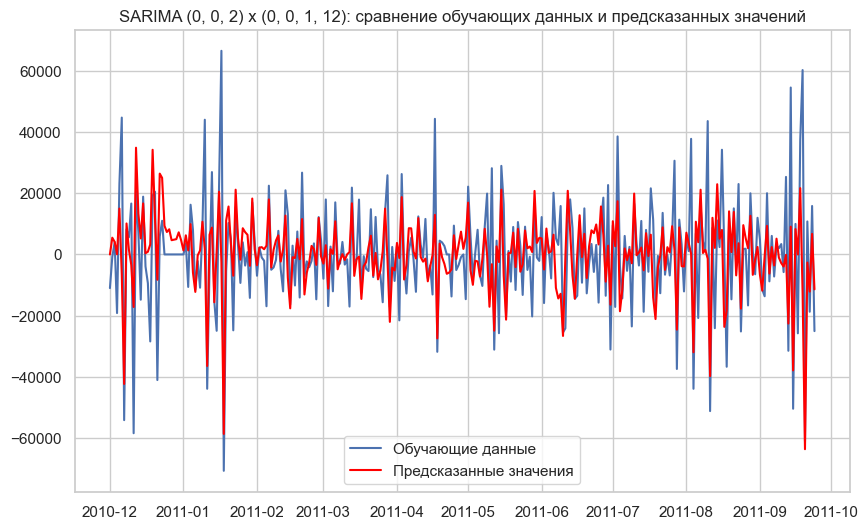

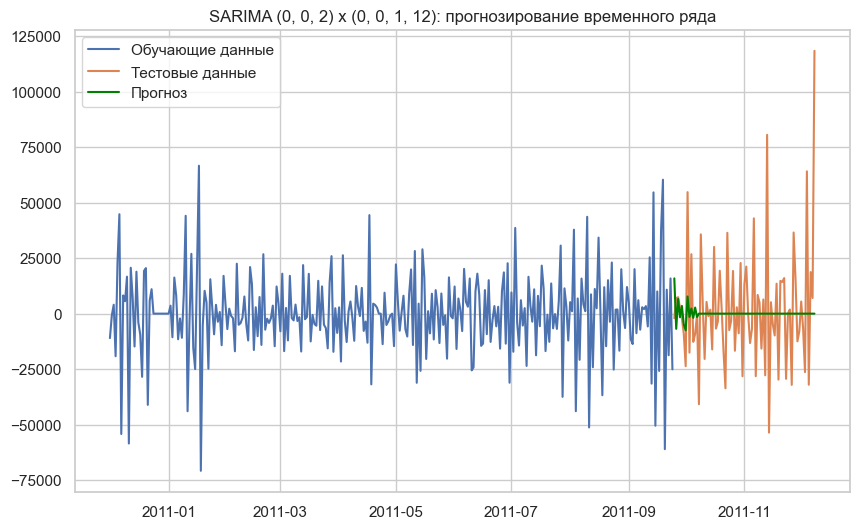

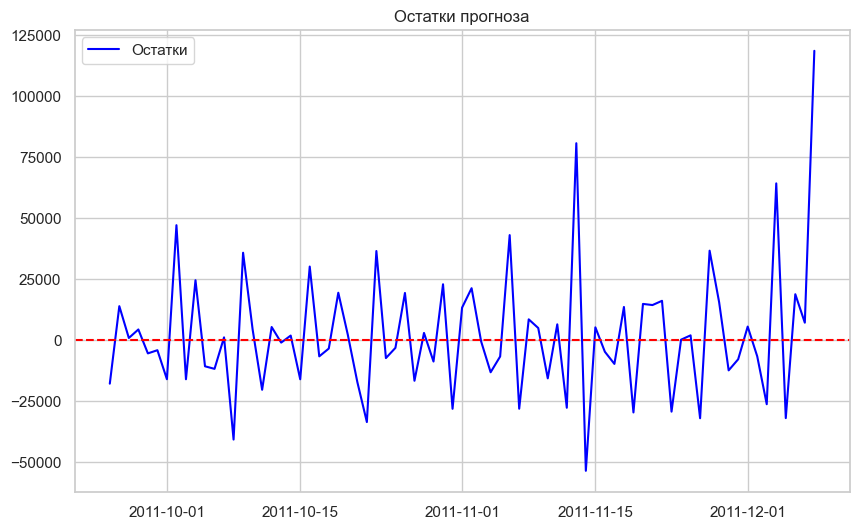

Mean Absolute Error (MAE): 18723.427
Mean Squared Error (MSE): 719450631.140
Root Mean Squared Error (RMSE): 26822.577
Mean Absolute Percentage Error (MAPE): nan%
Best model: SARIMA (0, 0, 2) x (0, 0, 1, 12)

На обучающей выборке предсказанные значения в целом следуют за трендом обучающих данных, с некоторыми отклонениями на экстремальных выбросах.
Это указывает на то, что модель адекватно улавливает основные тенденции временного ряда.
Лучшая модель: SARIMA(0, 0, 2) x (0, 0, 1, 12)


Моделирование на тестовой выборке, низкие метрики качества, график остатков, не являющийся белым шумом,
показывают, что лучшая модель SARIMA(0, 0, 2) x (0, 0, 1, 12) не способна адекватно предсказывать резкие колебания во временном ряде,
что приводит к значительным отклонениям от реальных значений.



In [50]:
%load_ext autoreload
%autoreload 2
from Modules.modeling import sarima_model

# Обучение модели  с автоподбором параметров и получение прогноза
SARIMA_auto_model, SARIMA_auto_forecast, SARIMA_auto_fitted_values, SARIMA_auto_mae, SARIMA_auto_mse, SARIMA_auto_rmse, SARIMA_auto_mape, SARIMA_order, SARIMA_seasonal_order = sarima_model(train_data, test_data)

print(f"""
На обучающей выборке явно точнее совпдают пиковые значения чем у ARIMA.
Лучшая модель: SARIMA({SARIMA_order[0]}, {SARIMA_order[1]}, {SARIMA_order[2]}) x ({SARIMA_seasonal_order[0]}, {SARIMA_seasonal_order[1]}, {SARIMA_seasonal_order[2]}, {SARIMA_seasonal_order[3]})
""")
SARIMA
print(f"""
Моделирование на тестовой выборке, низкие метрики качества, график остатков, не являющийся белым шумом,
показывают, что лучшая модель SARIMA({SARIMA_order[0]}, {SARIMA_order[1]}, {SARIMA_order[2]}) x ({SARIMA_seasonal_order[0]}, {SARIMA_seasonal_order[1]}, {SARIMA_seasonal_order[2]}, {SARIMA_seasonal_order[3]}) не 
значительно риблизила нас к адекватному предсказанию.
""")

In [56]:
# Сравнение метрик ARIMA и SARIMA
print(f"""Сравнение метрик SARIMA({SARIMA_order[0]}, {SARIMA_order[1]}, {SARIMA_order[2]}) x ({SARIMA_seasonal_order[0]}, {SARIMA_seasonal_order[1]}, {SARIMA_seasonal_order[2]}, {SARIMA_seasonal_order[3]}) и ARIMA({ARIMA_best_model.order[0]},{ARIMA_best_model.order[1]},{ARIMA_best_model.order[2]})

MAE (Mean Absolute Error): SARIMA = {SARIMA_auto_mae:.3f} < ARIMA = {ARIMA_auto_mae:.3f}.
MSE (Mean Squared Error):  SARIMA = {SARIMA_auto_mse:.3f} < ARIMA = {ARIMA_auto_mse:.3f}.
RMSE (Root Mean Squared Error): SARIMA = {SARIMA_auto_rmse:.3f} < ARIMA = {ARIMA_auto_rmse:.3f}).

Модель SARIMA({SARIMA_order[0]}, {SARIMA_order[1]}, {SARIMA_order[2]}) x ({SARIMA_seasonal_order[0]}, {SARIMA_seasonal_order[1]}, {SARIMA_seasonal_order[2]}, {SARIMA_seasonal_order[3]}) точнее, хоть и не значительно.""")

Сравнение метрик SARIMA(0, 0, 2) x (0, 0, 1, 12) и ARIMA(0,0,2)

MAE (Mean Absolute Error): SARIMA = 18723.427 < ARIMA = 18921.477.
MSE (Mean Squared Error):  SARIMA = 719450631.140 < ARIMA = 734245326.329.
RMSE (Root Mean Squared Error): SARIMA = 26822.577 < ARIMA = 27096.962).

Модель SARIMA(0, 0, 2) x (0, 0, 1, 12) точнее, хоть и не значительно.


In [ ]:
# 7.5 LSTM с автоподбором параметров

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


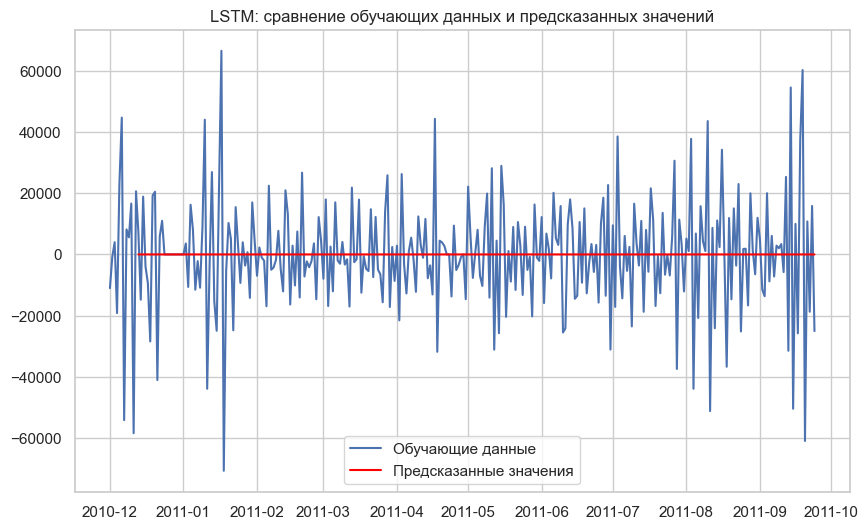

Произошла ошибка: x and y must have same first dimension, but have shapes (75,) and (63,)
75


TypeError: object of type 'NoneType' has no len()

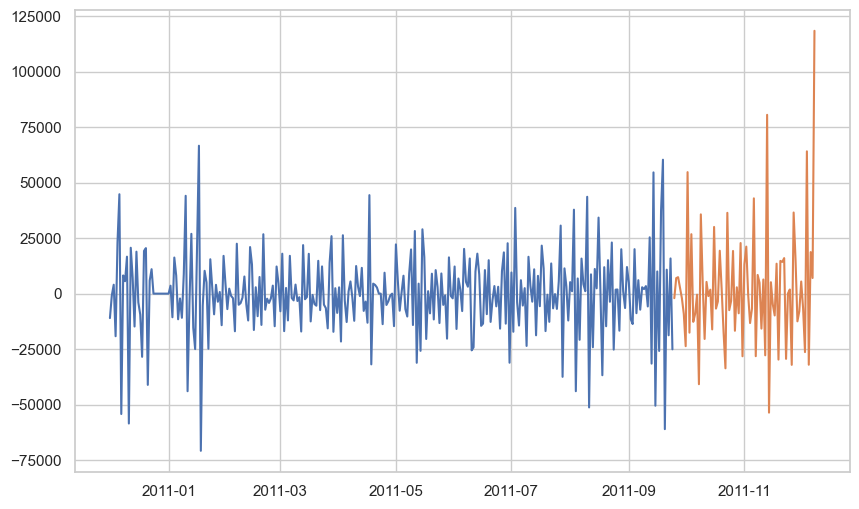

In [62]:
%load_ext autoreload
%autoreload 2
from Modules.modeling import lstm_model
seq_length = 12  # Длина последовательности
n_features = 1  # Количество признаков

LSTM_model, LSTM_forecast, LSTM_fitted_values, LSTM_mae, LSTM_mse, LSTM_rmse, LSTM_mape = lstm_model(train_data, test_data, seq_length, n_features)

# Проверка длины данных
print(len(test_data.index))
print(len(LSTM_forecast))

print(f"""
На обучающей выборке предсказанные значения в целом следуют за трендом обучающих данных.
Лучшая модель: LSTM с параметрами seq_length={seq_length}, n_features={n_features}
""")

print(f"""
Моделирование на тестовой выборке показывает, что LSTM имеет несколько лучшие метрики, чем ARIMA и SARIMA.
""")

# Сравнение метрик ARIMA, SARIMA и LSTM
print(f"""Сравнение метрик LSTM (seq_length={seq_length}, n_features={n_features}) и ARIMA({ARIMA_best_model.order[0]},{ARIMA_best_model.order[1]},{ARIMA_best_model.order[2]}) и SARIMA({SARIMA_order[0]}, {SARIMA_order[1]}, {SARIMA_order[2]}) x ({SARIMA_seasonal_order[0]}, {SARIMA_seasonal_order[1]}, {SARIMA_seasonal_order[2]}, {SARIMA_seasonal_order[3]})

MAE (Mean Absolute Error): LSTM = {LSTM_mae:.3f} < SARIMA = {SARIMA_auto_mae:.3f} < ARIMA = {ARIMA_auto_mae:.3f}.
MSE (Mean Squared Error):  LSTM = {LSTM_mse:.3f} < SARIMA = {SARIMA_auto_mse:.3f} < ARIMA = {ARIMA_auto_mse:.3f}.
RMSE (Root Mean Squared Error): LSTM = {LSTM_rmse:.3f} < SARIMA = {SARIMA_auto_rmse:.3f} < ARIMA = {ARIMA_auto_rmse:.3f}).

Модель LSTM (seq_length={seq_length}, n_features={n_features}) показывает лучшие результаты на тестовой выборке.""")

In [61]:
# Проверка длины данных
print(len(test_data.index))
print(len(LSTM_forecast))

75


NameError: name 'LSTM_forecast' is not defined